In [1]:
import pandas as pd
import numpy as np
import re
import json
from pandas.io.json import json_normalize
import os
import glob

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [3]:
originaldb=pd.read_csv('./data.csv')
originaldb.head()

,Index,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
originaldb.columns

Index(['Index', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle

In [5]:
originaldb.dtypes

Index               int64
ID                  int64
Name               object
Age                 int64
Photo              object
                   ...   
GKHandling        float64
GKKicking         float64
GKPositioning     float64
GKReflexes        float64
Release Clause     object
Length: 89, dtype: object

In [6]:
originaldb = originaldb.rename(columns={'International Reputation': 'Int Reputation'})
originaldb = originaldb.rename(columns={'HeadingAccuracy': 'HeadAccuracy'})
originaldb = originaldb.rename(columns={'ShortPassing': 'ShortPass'})
originaldb = originaldb.rename(columns={'LongPassing': 'LongPass'})
originaldb = originaldb.rename(columns={'Jersey Number': 'Jersey'})
originaldb = originaldb.rename(columns={'Value': 'Value(€M)'})
originaldb = originaldb.rename(columns={'Wage': 'Wage(€K)'})
originaldb = originaldb.rename(columns={'Release Clause': 'Release Clause(€M)'})
originaldb = originaldb.rename(columns={'Contract Valid Until': 'Contract Expiry'})
originaldb = originaldb.rename(columns={'Height': 'Height(cm)'})
originaldb = originaldb.rename(columns={'Weight': 'Weight(kgs)'})

In [7]:
empty_values=originaldb.isnull().sum()
empty_values

Index                    0
ID                       0
Name                     0
Age                      0
Photo                    0
                      ... 
GKHandling              48
GKKicking               48
GKPositioning           48
GKReflexes              48
Release Clause(€M)    1564
Length: 89, dtype: int64

In [8]:
fifadb=originaldb.drop(columns=['ID','Body Type','Photo', 'Flag', 'Club Logo', 'Real Face', 'Loaned From'])

In [9]:
fifadb

,Index,Name,Age,Nationality,Overall,Potential,Club,Value(€M),Wage(€K),Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause(€M)
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,J. Lundstram,19,England,47,65,Crewe Alexandra,€60K,€1K,1307,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,N. Christoffersson,19,Sweden,47,63,Trelleborgs FF,€60K,€1K,1098,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,B. Worman,16,England,47,67,Cambridge United,€60K,€1K,1189,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,D. Walker-Rice,17,England,47,66,Tranmere Rovers,€60K,€1K,1228,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [10]:
null_cols=fifadb.isnull().sum()
null_cols[null_cols>0]

Club                   241
Preferred Foot          48
Int Reputation          48
Weak Foot               48
Skill Moves             48
                      ... 
GKHandling              48
GKKicking               48
GKPositioning           48
GKReflexes              48
Release Clause(€M)    1564
Length: 73, dtype: int64

In [11]:
fifadb.describe()

,Index,Age,Overall,Potential,Special,Int Reputation,Weak Foot,Skill Moves,Jersey,Crossing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [12]:
fifadb['ShortPass'].fillna(fifadb['ShortPass'].mean(), inplace = True)
fifadb['Volleys'].fillna(fifadb['Volleys'].mean(), inplace = True)
fifadb['Dribbling'].fillna(fifadb['Dribbling'].mean(), inplace = True)
fifadb['Curve'].fillna(fifadb['Curve'].mean(), inplace = True)
fifadb['FKAccuracy'].fillna(fifadb['FKAccuracy'], inplace = True)
fifadb['LongPass'].fillna(fifadb['LongPass'].mean(), inplace = True)
fifadb['BallControl'].fillna(fifadb['BallControl'].mean(), inplace = True)
fifadb['HeadAccuracy'].fillna(fifadb['HeadAccuracy'].mean(), inplace = True)
fifadb['Finishing'].fillna(fifadb['Finishing'].mean(), inplace = True)
fifadb['Crossing'].fillna(fifadb['Crossing'].mean(), inplace = True)
fifadb['Contract Expiry'].fillna(2043, inplace = True)
fifadb['Joined'].fillna('Jan 1, 2019', inplace = True)
fifadb['Jersey'].fillna(0, inplace = True)
fifadb['Position'].fillna('ST', inplace = True)
fifadb['Club'].fillna('No Club', inplace = True)
fifadb['Work Rate'].fillna('Medium/ Medium', inplace = True)
fifadb['Skill Moves'].fillna(fifadb['Skill Moves'].median(), inplace = True)
fifadb['Weak Foot'].fillna(3, inplace = True)
fifadb['Preferred Foot'].fillna('Right', inplace = True)
fifadb['Int Reputation'].fillna(1, inplace = True)
fifadb['Wage(€K)'].fillna('€200K', inplace = True)

In [13]:
fifadb.fillna(0, inplace=True)

In [14]:
fifadb.columns

Index(['Index', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value(€M)', 'Wage(€K)', 'Special', 'Preferred Foot', 'Int Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Jersey', 'Joined',
       'Contract Expiry', 'Height(cm)', 'Weight(kgs)', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadAccuracy', 'ShortPass', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPass', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Release Clause(€M

In [15]:
null_cols=fifadb.isnull().sum()
null_cols[null_cols>0]

Series([], dtype: int64)

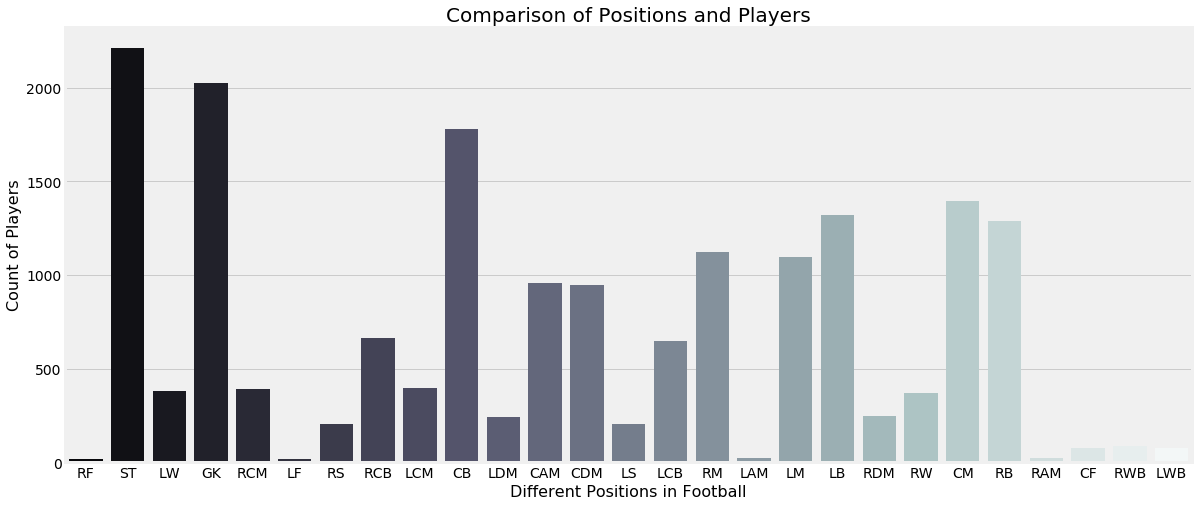

In [16]:
plt.figure(figsize = (18, 8))
plt.style.use('fivethirtyeight')
ax = sns.countplot(fifadb['Position'], palette = 'bone')
ax.set_xlabel(xlabel = 'Different Positions in Football', fontsize = 16)
ax.set_ylabel(ylabel = 'Count of Players', fontsize = 16)
ax.set_title(label = 'Comparison of Positions and Players', fontsize = 20)
plt.show()

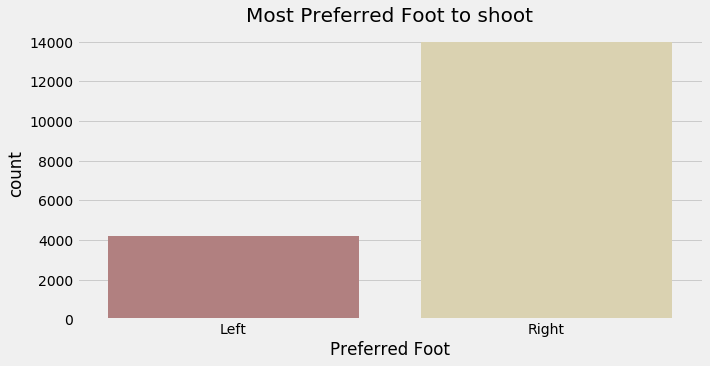

In [17]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(fifadb['Preferred Foot'], palette = 'pink')
plt.title('Most Preferred Foot to shoot', fontsize = 20)
plt.show()

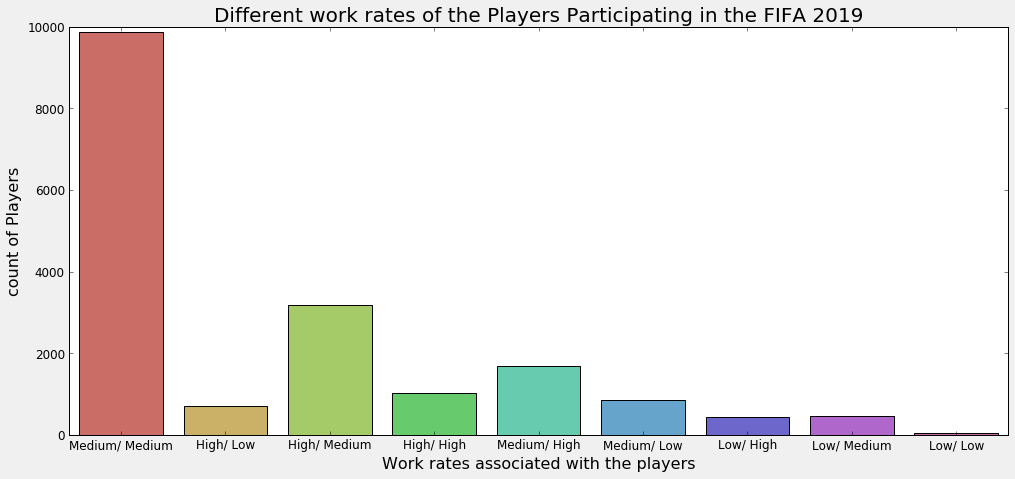

In [18]:
plt.figure(figsize = (15, 7))
plt.style.use('_classic_test')

sns.countplot(x = fifadb['Work Rate'], palette = 'hls')
plt.title('Different work rates of the Players Participating in the FIFA 2019', fontsize = 20)
plt.xlabel('Work rates associated with the players', fontsize = 16)
plt.ylabel('count of Players', fontsize = 16)
plt.show()

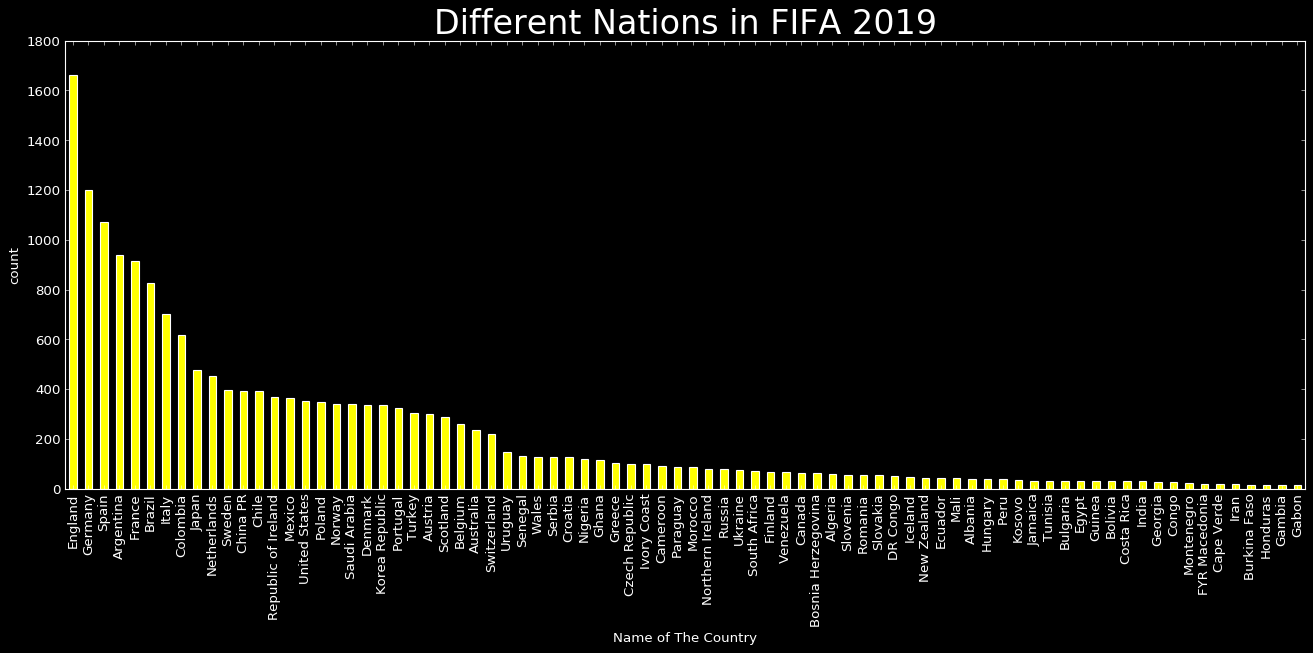

In [19]:
plt.style.use('dark_background')
fifadb['Nationality'].value_counts().head(80).plot.bar(color = 'yellow', figsize = (20, 7))
plt.title('Different Nations in FIFA 2019', fontsize = 30, fontweight = 20)
plt.xlabel('Name of The Country')
plt.ylabel('count')
plt.show()

In [20]:
fifadb['Release Clause(€M)'] = fifadb['Release Clause(€M)'].replace('€','')
fifadb['Release Clause(€M)'] = fifadb['Release Clause(€M)'].replace('‚Ç¨','')

In [21]:
fifadb['Release Clause(€M)'] = fifadb['Release Clause(€M)'].apply(lambda x: str(x))

In [22]:
def extract_value_from(Value):
    out = Value.replace('€', '')
    if 'M' in out:
        out = float(out.replace('M', ''))*1000000
    elif 'K' in Value:
        out = float(out.replace('K', ''))*1000
    return float(out)

In [23]:
fifadb['Value(€M)'] = fifadb['Value(€M)'].apply(lambda x: extract_value_from(x))
fifadb['Wage(€K)'] = fifadb['Wage(€K)'].apply(lambda x: extract_value_from(x))
fifadb['Release Clause(€M)'] = fifadb['Release Clause(€M)'].apply(lambda x: extract_value_from(x))

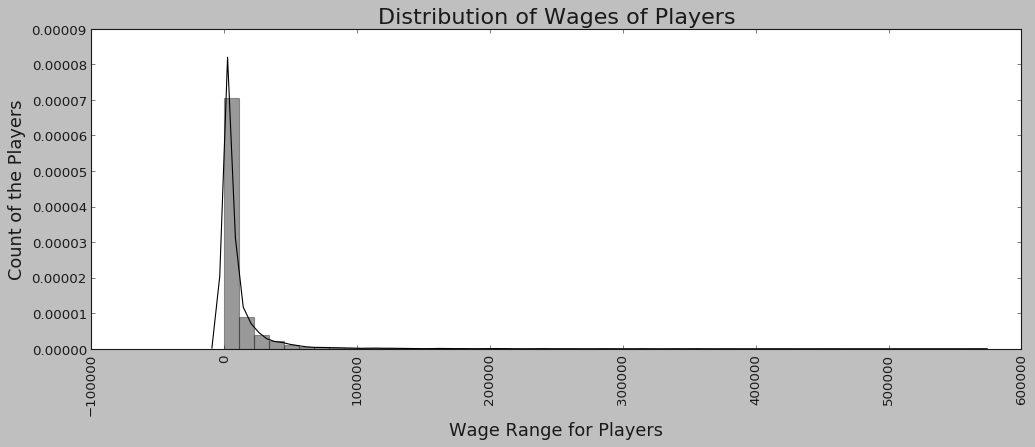

In [173]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(fifadb['Wage(€K)'], color = 'black')
plt.xlabel('Wage Range for Players', fontsize = 16)
plt.ylabel('Count of the Players', fontsize = 16)
plt.title('Distribution of Wages of Players', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [25]:
fifadb['Weight(kgs)'] = fifadb['Weight(kgs)'].str.replace('lbs', '')

In [26]:
fifadb['Weight(kgs)'] = fifadb['Weight(kgs)'].fillna(0)
fifadb['Release Clause(€M)'] = fifadb['Release Clause(€M)'].fillna(0)

In [27]:
fifadb['Weight(kgs)'].unique()

array(['159', '183', '150', '168', '154', '163', '146', '190', '181',
       '192', '176', '172', '148', '165', '196', '161', '187', '212',
       '170', '203', '157', '185', '130', '174', '207', '134', '141',
       '152', '179', '132', '201', '198', '209', '214', '143', '205',
       '137', '194', '216', '139', '220', '126', '218', '123', '227',
       '128', '223', '225', '121', '115', '117', '236', '229', '243', 0,
       '110', '119', '234'], dtype=object)

In [28]:
fifadb['Weight(kgs)'] = fifadb['Weight(kgs)'].apply(lambda x: int(x))

In [29]:
fifadb['Weight(kgs)'] = [x*0.453692 for x in fifadb['Weight(kgs)']]

In [30]:
fifadb['Weight(kgs)'].unique

<bound method Series.unique of 0        72.137028
1        83.025636
2        68.053800
3        76.220256
4        69.868568
           ...    
18202    60.794728
18203    77.127640
18204    67.146416
18205    69.868568
18206    79.849792
Name: Weight(kgs), Length: 18207, dtype: float64>

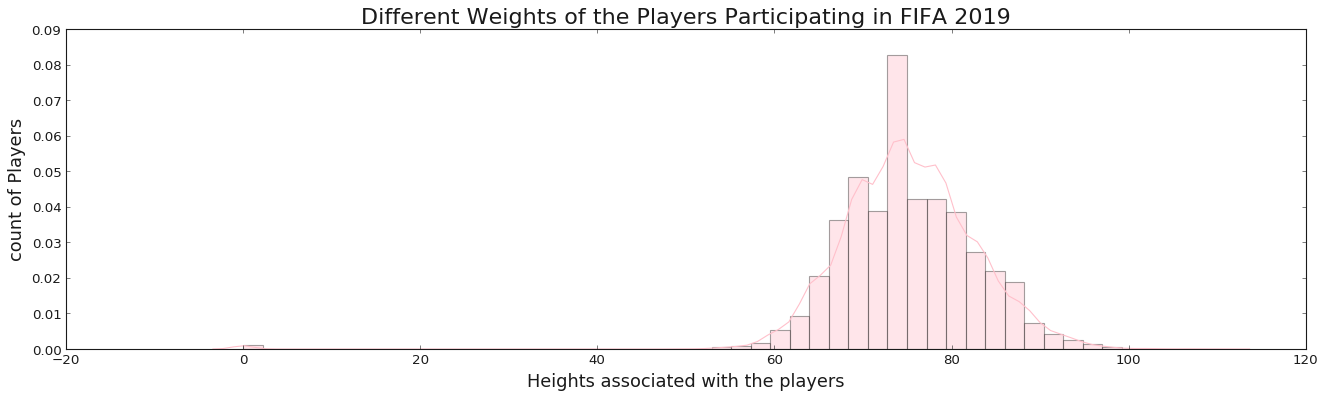

In [170]:
plt.figure(figsize = (20, 5))
plt.style.use('_classic_test')
sns.distplot(fifadb['Weight(kgs)'], color = 'pink')
plt.title('Different Weights of the Players Participating in FIFA 2019', fontsize = 20)
plt.xlabel('Heights associated with the players', fontsize = 16)
plt.ylabel('count of Players', fontsize = 16)
plt.show()

In [32]:
fifadb['Height(cm)'].unique()

array(["5'7", "6'2", "5'9", "6'4", "5'11", "5'8", "6'0", "5'6", "5'10",
       "6'6", "6'1", "5'4", "6'3", "5'5", "6'5", "6'7", "5'3", "5'2",
       "6'8", "5'1", "6'9", 0], dtype=object)

In [33]:
def fifadb_hght(a):
    if isinstance(a, str):
        if "5'1" in a:
            return 155
        elif "5'2" in a:
            return 157
        elif "5'3" in a:
            return 160
        elif "5'4" in a:
            return 163
        elif "5'5" in a:
            return 165
        elif "5'6" in a:
            return 168
        elif "5'7" in a:
            return 170
        elif "5'8" in a:
            return 173
        elif "5'9" in a:
            return 175
        elif "5'10" in a:
            return 178
        elif "5'11" in a:
            return 180
        elif "6'0" in a:
            return 183
        elif "6'1" in a:
            return 185
        elif "6'2" in a:
            return 188
        elif "6'3" in a:
            return 191
        elif "6'4" in a:
            return 193
        elif "6'5" in a:
            return 196
        elif "6'6" in a:
            return 198
        elif "6'7" in a:
            return 201
        elif "6'8" in a:
            return 203
        elif "6'9" in a:
            return 206
        else:
            return 0
    else:
        return 0

In [34]:
fifadb['Height(cm)'] = fifadb['Height(cm)'].apply(lambda x: fifadb_hght(x))

In [35]:
fifadb['Height(cm)'].unique()

array([170, 188, 175, 193, 155, 173, 183, 168, 198, 185, 163, 191, 165,
       196, 201, 160, 157, 203, 206,   0])

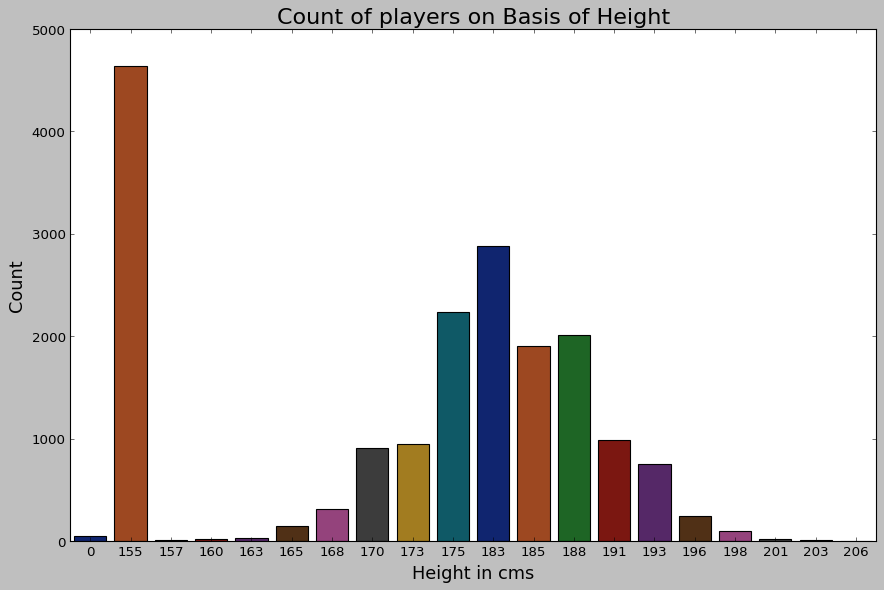

In [36]:
plt.figure(figsize = (13, 8))
ax = sns.countplot(x = fifadb['Height(cm)'], palette = 'dark')
ax.set_title(label = 'Count of players on Basis of Height', fontsize = 20)
ax.set_xlabel(xlabel = 'Height in cms', fontsize = 16)
ax.set_ylabel(ylabel = 'Count', fontsize = 16)
plt.show()

In [37]:
fifadb['LS'] = fifadb['LS'].apply(lambda x: str(x).split('+'))
fifadb['ST'] = fifadb['ST'].apply(lambda x: str(x).split('+'))
fifadb['RS'] = fifadb['RS'].apply(lambda x: str(x).split('+'))
fifadb['LW'] = fifadb['LW'].apply(lambda x: str(x).split('+'))
fifadb['LF'] = fifadb['LF'].apply(lambda x: str(x).split('+'))
fifadb['CF'] = fifadb['CF'].apply(lambda x: str(x).split('+'))
fifadb['RF'] = fifadb['RF'].apply(lambda x: str(x).split('+'))
fifadb['RW'] = fifadb['RW'].apply(lambda x: str(x).split('+'))
fifadb['LAM'] = fifadb['LAM'].apply(lambda x: str(x).split('+'))
fifadb['CAM'] = fifadb['CAM'].apply(lambda x: str(x).split('+'))
fifadb['RAM'] = fifadb['RAM'].apply(lambda x: str(x).split('+'))
fifadb['LM'] = fifadb['LM'].apply(lambda x: str(x).split('+'))
fifadb['LCM'] = fifadb['LCM'].apply(lambda x: str(x).split('+'))
fifadb['CM'] = fifadb['CM'].apply(lambda x: str(x).split('+'))
fifadb['RCM'] = fifadb['RCM'].apply(lambda x: str(x).split('+'))
fifadb['RM'] = fifadb['RM'].apply(lambda x: str(x).split('+'))
fifadb['LWB'] = fifadb['LWB'].apply(lambda x: str(x).split('+'))
fifadb['LDM'] = fifadb['LDM'].apply(lambda x: str(x).split('+'))
fifadb['CDM'] = fifadb['CDM'].apply(lambda x: str(x).split('+'))
fifadb['RDM'] = fifadb['RDM'].apply(lambda x: str(x).split('+'))
fifadb['RWB'] = fifadb['RWB'].apply(lambda x: str(x).split('+'))
fifadb['LB'] = fifadb['LB'].apply(lambda x: str(x).split('+'))
fifadb['LCB'] = fifadb['LCB'].apply(lambda x: str(x).split('+'))
fifadb['CB'] = fifadb['CB'].apply(lambda x: str(x).split('+'))
fifadb['RCB'] = fifadb['RCB'].apply(lambda x: str(x).split('+'))
fifadb['RB'] = fifadb['RB'].apply(lambda x: str(x).split('+'))

In [38]:
fifadb['LS'] = [i[0] for i in fifadb['LS']]
fifadb['ST'] = [i[0] for i in fifadb['ST']]
fifadb['RS'] = [i[0] for i in fifadb['RS']]
fifadb['LW'] = [i[0] for i in fifadb['LW']]
fifadb['LF'] = [i[0] for i in fifadb['LF']]
fifadb['CF'] = [i[0] for i in fifadb['CF']]
fifadb['RF'] = [i[0] for i in fifadb['RF']]
fifadb['RW'] = [i[0] for i in fifadb['RW']]
fifadb['LAM'] = [i[0] for i in fifadb['LAM']]
fifadb['CAM'] = [i[0] for i in fifadb['CAM']]
fifadb['RAM'] = [i[0] for i in fifadb['RAM']]
fifadb['LM'] = [i[0] for i in fifadb['LM']]
fifadb['LCM'] = [i[0] for i in fifadb['LCM']]
fifadb['CM'] = [i[0] for i in fifadb['CM']]
fifadb['RCM'] = [i[0] for i in fifadb['RCM']]
fifadb['RM'] = [i[0] for i in fifadb['RM']]
fifadb['LWB'] = [i[0] for i in fifadb['LWB']]
fifadb['LDM'] = [i[0] for i in fifadb['LDM']]
fifadb['CDM'] = [i[0] for i in fifadb['CDM']]
fifadb['RDM'] = [i[0] for i in fifadb['RDM']]
fifadb['RWB'] = [i[0] for i in fifadb['RWB']]
fifadb['LB'] = [i[0] for i in fifadb['LB']]
fifadb['LCB'] = [i[0] for i in fifadb['LCB']]
fifadb['CB'] = [i[0] for i in fifadb['CB']]
fifadb['RCB'] = [i[0] for i in fifadb['RCB']]
fifadb['RB'] = [i[0] for i in fifadb['RB']]

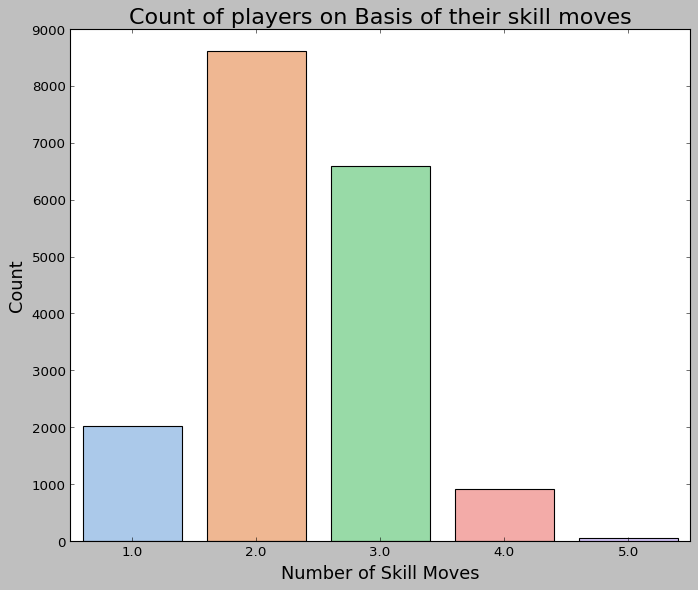

In [39]:
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = fifadb['Skill Moves'], palette = 'pastel')
ax.set_title(label = 'Count of players on Basis of their skill moves', fontsize = 20)
ax.set_xlabel(xlabel = 'Number of Skill Moves', fontsize = 16)
ax.set_ylabel(ylabel = 'Count', fontsize = 16)
plt.show()

In [40]:
fifadb['Age'].unique()

array([31, 33, 26, 27, 32, 25, 29, 28, 24, 30, 19, 40, 22, 23, 34, 35, 36,
       37, 21, 18, 20, 39, 41, 17, 38, 45, 42, 16, 44])

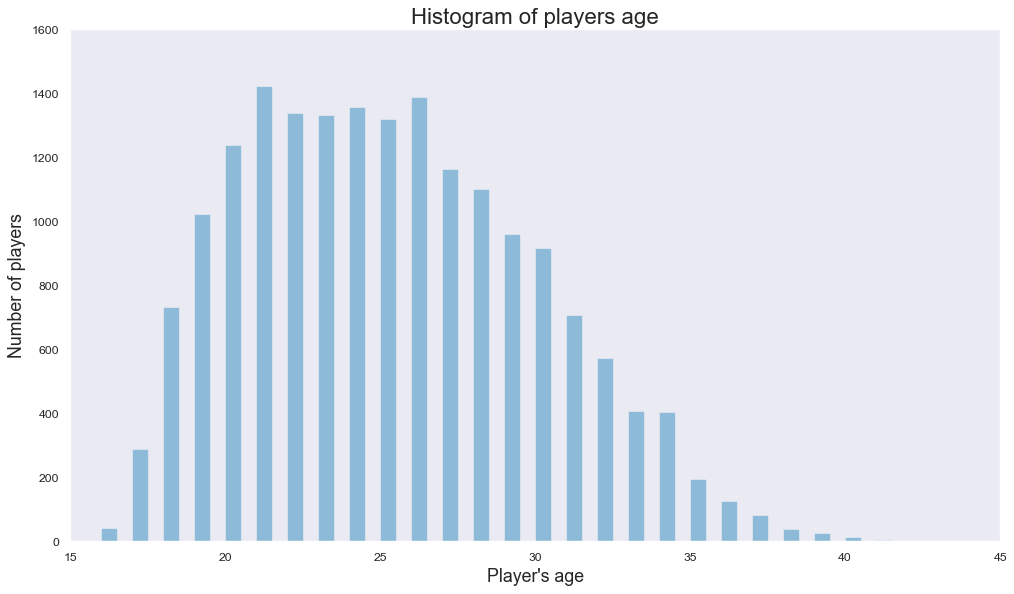

In [41]:
sns.set(style = "dark", palette = "colorblind", color_codes = True)
x = fifadb.Age
plt.figure(figsize = (15,8))
ax = sns.distplot(x, bins = 58, kde = False, color = 'b')
ax.set_xlabel(xlabel = "Player\'s age", fontsize = 16)
ax.set_ylabel(ylabel = 'Number of players', fontsize = 16)
ax.set_title(label = 'Histogram of players age', fontsize = 20)
plt.show()

In [169]:
fifadb.describe()

,Index,Age,Overall,Potential,Value(€M),Wage(€K),Special,Int Reputation,Weak Foot,Skill Moves,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause(€M)
count,18207.000000,18207.000000,18207.000000,18207.000000,1.820700e+04,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,...,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,1.820700e+04
mean,9103.000000,25.122206,66.238699,71.307299,2.410696e+06,9731.312133,1597.809908,1.112924,2.947438,2.360356,...,58.493656,47.156973,47.572088,45.541056,16.572417,16.348382,16.189268,16.345691,16.666831,4.191200e+06
std,5256.052511,4.669943,6.908930,6.136496,5.594933e+06,21999.290406,272.586016,0.393554,0.659591,0.755394,...,11.810375,20.025458,21.773243,21.389596,17.692536,16.905507,16.502101,17.032944,17.951898,1.070778e+07
min,0.000000,16.000000,46.000000,48.000000,0.000000e+00,0.000000,731.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4551.500000,21.000000,62.000000,67.000000,3.000000e+05,1000.000000,1457.000000,1.000000,3.000000,2.000000,...,51.000000,30.000000,26.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000,3.920000e+05
50%,9103.000000,25.000000,66.000000,71.000000,6.750000e+05,3000.000000,1635.000000,1.000000,3.000000,2.000000,...,59.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000,1.000000e+06
75%,13654.500000,28.000000,71.000000,75.000000,2.000000e+06,9000.000000,1787.000000,1.000000,3.000000,3.000000,...,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000,3.000000e+06
max,18206.000000,45.000000,94.000000,95.000000,1.185000e+08,565000.000000,2346.000000,5.000000,5.000000,5.000000,...,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000,2.281000e+08


In [42]:
fifadb['Club'].value_counts()

No Club                241
Southampton             33
Fortuna Düsseldorf      33
Rayo Vallecano          33
FC Barcelona            33
                      ... 
Fluminense              20
Atlético Paranaense     20
Limerick FC             19
Sligo Rovers            19
Derry City              18
Name: Club, Length: 652, dtype: int64

In [43]:
fifadb.groupby(fifadb['Club'])['Nationality'].nunique().sort_values(ascending = False).head(10)

Club
No Club                   28
Brighton & Hove Albion    21
Fulham                    19
Udinese                   18
Napoli                    18
Empoli                    18
Eintracht Frankfurt       18
West Ham United           18
AS Monaco                 18
Lazio                     18
Name: Nationality, dtype: int64

In [44]:
fifadb.iloc[fifadb.groupby(fifadb['Position'])['Overall'].idxmax()][['Position', 'Name', 'Age', 'Club', 'Nationality']]

,Position,Name,Age,Club,Nationality
17,CAM,A. Griezmann,27,Atlético Madrid,France
12,CB,D. Godín,32,Atlético Madrid,Uruguay
20,CDM,Sergio Busquets,29,FC Barcelona,Spain
271,CF,Luis Alberto,25,Lazio,Spain
67,CM,Thiago,27,FC Bayern München,Spain
3,GK,De Gea,27,Manchester United,Spain
28,LAM,J. Rodríguez,26,FC Bayern München,Colombia
35,LB,Marcelo,30,Real Madrid,Brazil
24,LCB,G. Chiellini,33,Juventus,Italy
11,LCM,T. Kroos,28,Real Madrid,Germany


In [45]:
fifadb.iloc[fifadb.groupby(fifadb['Position'])['Potential'].idxmax()][['Position', 'Name', 'Age', 'Club', 'Nationality']]

,Position,Name,Age,Club,Nationality
31,CAM,C. Eriksen,26,Tottenham Hotspur,Denmark
42,CB,S. Umtiti,24,FC Barcelona,France
27,CDM,Casemiro,26,Real Madrid,Brazil
350,CF,A. Milik,24,Napoli,Poland
78,CM,S. Milinković-Savić,23,Lazio,Serbia
3,GK,De Gea,27,Manchester United,Spain
28,LAM,J. Rodríguez,26,FC Bayern München,Colombia
35,LB,Marcelo,30,Real Madrid,Brazil
77,LCB,M. Škriniar,23,Inter,Slovakia
11,LCM,T. Kroos,28,Real Madrid,Germany


In [46]:
eldest = fifadb.sort_values('Age', ascending = False)[['Name', 'Age', 'Club', 'Nationality']].head(15)
print(eldest)

                  Name  Age                          Club        Nationality
4741          O. Pérez   45                       Pachuca             Mexico
18183    K. Pilkington   44              Cambridge United            England
17726        T. Warner   44            Accrington Stanley  Trinidad & Tobago
10545      S. Narazaki   42                Nagoya Grampus              Japan
7225          C. Muñoz   41  CD Universidad de Concepción          Argentina
1120         J. Villar   41                       No Club           Paraguay
12192     H. Sulaimani   41                     Ohod Club       Saudi Arabia
15426         M. Tyler   41           Peterborough United            England
4228          B. Nivet   41                  ESTAC Troyes             France
10356         F. Kippe   40                 Lillestrøm SK             Norway
16264  P. van der Vlag   40                      FC Emmen        Netherlands
9484       B. Castillo   40                Atlético Huila           Colombia

In [47]:
youngest = fifadb.sort_values('Age', ascending = True)[['Name', 'Age', 'Club', 'Nationality']].head(15)
print(youngest)

                 Name  Age               Club          Nationality
18206       G. Nugent   16    Tranmere Rovers              England
17743       J. Olstad   16    Sarpsborg 08 FF               Norway
13293     H. Massengo   16          AS Monaco               France
16081     J. Italiano   16        Perth Glory            Australia
18166        N. Ayéva   16          Örebro SK               Sweden
17712        K. Broda   16       Wisła Kraków               Poland
17354     L. D'Arrigo   16    Adelaide United            Australia
13567  Y. Verschaeren   16     RSC Anderlecht              Belgium
16927       B. Nygren   16       IFK Göteborg               Sweden
18018     B. O'Gorman   16     Bray Wanderers  Republic of Ireland
17091        A. Doğan   16        Kayserispor               Turkey
17115      C. Bassett   16    Colorado Rapids        United States
15793        J. Lahne   16  IF Brommapojkarna               Sweden
15746     Y. Begraoui   16         AJ Auxerre               Fr

In [48]:
fifadb[fifadb['Preferred Foot'] == 'Left'][['Name', 'Age', 'Club', 'Nationality']].head(10)

,Name,Age,Club,Nationality
0,L. Messi,31,FC Barcelona,Argentina
13,David Silva,32,Manchester City,Spain
15,P. Dybala,24,Juventus,Argentina
17,A. Griezmann,27,Atlético Madrid,France
19,T. Courtois,26,Real Madrid,Belgium
24,G. Chiellini,33,Juventus,Italy
26,M. Salah,26,Liverpool,Egypt
28,J. Rodríguez,26,FC Bayern München,Colombia
35,Marcelo,30,Real Madrid,Brazil
36,G. Bale,28,Real Madrid,Wales


In [49]:
fifadb[fifadb['Preferred Foot'] == 'Right'][['Name', 'Age', 'Club', 'Nationality']].head(10)

,Name,Age,Club,Nationality
1,Cristiano Ronaldo,33,Juventus,Portugal
2,Neymar Jr,26,Paris Saint-Germain,Brazil
3,De Gea,27,Manchester United,Spain
4,K. De Bruyne,27,Manchester City,Belgium
5,E. Hazard,27,Chelsea,Belgium
6,L. Modrić,32,Real Madrid,Croatia
7,L. Suárez,31,FC Barcelona,Uruguay
8,Sergio Ramos,32,Real Madrid,Spain
9,J. Oblak,25,Atlético Madrid,Slovenia
10,R. Lewandowski,29,FC Bayern München,Poland


In [50]:
from urllib.request import urlopen
import requests
import time
from bs4 import BeautifulSoup as bs

In [51]:
file = "NationalTeams.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
for page in range(33,38):
    url = "https://www.pesmaster.com/national-teams-europe/pes-2020/league/{}".format(page)
    html = urlopen(url)
    soup = bs(html,"html.parser")
    Title = soup.find_all("div", {"class":"team-block-inner"})
    for i in Title:
        try:
            stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

86 France
85 Germany
85 Spain
84 Belgium
84 Italy
83 England
83 Netherlands
83 Portugal
80 Croatia
80 Poland
80 Russia
80 Serbia
80 Switzerland
79 Denmark
79 Ukraine
78 Austria
78 Turkey
77 Czech Republic
77 Greece
77 Norway
77 Sweden
76 Bosnia and Herzegovina
76 Scotland
76 Slovakia
75 Iceland
75 Ireland
75 Slovenia
75 Wales
85 Brazil
84 Argentina
82 Uruguay
81 Colombia
78 Chile
76 Paraguay
75 Peru
75 Iran
79 Senegal
78 Algeria
78 Côte d'Ivoire
78 Morocco
76 Cameroon
76 Nigeria
76 Tunisia
75 Ghana
78 Mexico


In [52]:
pd.read_csv('NationalTeams.csv')

,Stat,Name
0,86,France
1,85,Germany
2,85,Spain
3,84,Belgium
4,84,Italy
5,83,England
6,83,Netherlands
7,83,Portugal
8,80,Croatia
9,80,Poland


In [53]:
file = "AFC_Champs.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url1 = "https://www.pesmaster.com/afc-champions-league/pes-2020/league/8/"
html1 = urlopen(url1)
soup1 = bs(html1,"html.parser")
Title1 = soup1.find_all("div", {"class":"team-block-inner"})
for i in Title1:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

75 Al Ahli
68 Al Ain
71 Al Duhail
74 Al Hilal
73 Al Ittihad
72 Al Nassr
66 Al Rayyan
71 Al Sadd
67 Al Wahda
66 Al Wasl
64 Al Zawra'a
70 Beijing FC
68 Buriram United
69 Daegu
69 Esteghlal
71 Guangzhou Evergrande
69 Gyeongnam
70 Jeonbuk Hyundai Motors
67 Johor Darul Ta'Zim FC
70 Kashima Antlers
70 Kawasaki Frontale
66 Lokomotiv
69 Melbourne Victory
68 Pakhtakor
68 Persepolis
70 Sanfrecce Hiroshima
69 Shandong Luneng
70 Shanghai Sipg
69 Sydney FC
69 Ulsan Hyundai FC
70 Urawa Reds
67 Zob Ahan


In [54]:
file = "EnglishLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url2 = "https://www.pesmaster.com/english-league/pes-2020/league/9/"
html2 = urlopen(url2)
soup2 = bs(html2,"html.parser")
Title2 = soup2.find_all("div", {"class":"team-block-inner"})
for i in Title2:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

81 Arsenal
76 Aston Villa
77 Bournemouth
76 Brighton & Hove Albion
76 Burnley
82 Chelsea
77 Crystal Palace
80 Everton
78 Leicester City
84 Liverpool
86 Manchester City
81 Manchester United
77 Newcastle United
74 Norwich City
74 Sheffield United
77 Southampton
83 Tottenham Hotspur
77 Watford
79 West Ham United
77 Wolverhampton Wanderers


In [55]:
file = "ItalianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url3 = "https://www.pesmaster.com/serie-a-tim/pes-2020/league/10/"
html3 = urlopen(url3)
soup3 = bs(html3,"html.parser")
Title3 = soup3.find_all("div", {"class":"team-block-inner"})
for i in Title3:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

78 Atalanta
76 Bologna
74 Brescia
77 Cagliari Calcio
78 Fiorentina
76 Genoa
73 Hellas Verona
81 Internazionale
85 Juventus
80 Lazio
72 Lecce
81 Milan
82 Napoli
75 Parma Calcio 1913
80 Roma
76 Sampdoria
76 U.S. Sassuolo
75 SPAL
78 Torino
77 Udinese


In [56]:
file = "SpanishLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url4 = "https://www.pesmaster.com/spanish-league/pes-2020/league/11/"
html4 = urlopen(url4)
soup4 = bs(html4,"html.parser")
Title4 = soup4.find_all("div", {"class":"team-block-inner"})
for i in Title4:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

75 Alavés
85 Barcelona
77 Athletic Club
76 SD Eibar
78 Getafe CF
72 Granada CF
77 CD Leganés
76 Levante UD
77 RCD Espanyol
86 Real Madrid
83 Atlético de Madrid
71 RCD Mallorca
73 CA Osasuna
79 Sevilla FC
79 Real Betis
79 Valencia CF
74 Real Valladolid
77 Real Sociedad
78 Celta de Vigo
78 Villarreal


In [57]:
file = "FrenchLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url5 = "https://www.pesmaster.com/ligue-1-conforama/pes-2020/league/12/"
html5 = urlopen(url5)
soup5 = bs(html5,"html.parser")
Title5 = soup5.find_all("div", {"class":"team-block-inner"})
for i in Title5:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

75 Amiens
75 Angers
76 Bordeaux
72 Brest
73 Dijon
77 Lille
72 Metz
80 Monaco
76 Montpellier
75 Nantes
77 Nice
71 Nîmes
80 Olympique Lyonnais
79 Olympique Marseille
85 PSG
76 Rennes
77 Saint-Étienne
74 Stade de Reims
76 Strasbourg
75 Toulouse


In [58]:
file = "DutchLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url6 = "https://www.pesmaster.com/eredivisie/pes-2020/league/13/"
html6 = urlopen(url6)
soup6 = bs(html6,"html.parser")
Title6 = soup6.find_all("div", {"class":"team-block-inner"})
for i in Title6:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

71 ADO Den Haag
79 Ajax
72 AZ
70 Emmen
76 Feyenoord
68 Fortuna Sittard
71 Groningen
69 Heerenveen
70 Heracles
72 PEC Zwolle
78 PSV
67 RKC Waalwijk
69 Sparta Rotterdam
69 Twente
74 Utrecht
73 Vitesse
68 VVV
68 Willem II


In [59]:
file = "PortugueseLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url7 = "https://www.pesmaster.com/liga-nos/pes-2020/league/14/"
html7 = urlopen(url7)
soup7 = bs(html7,"html.parser")
Title7 = soup7.find_all("div", {"class":"team-block-inner"})
for i in Title7:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

68 CD Aves
69 Belenenses
79 Benfica
71 Boavista
69 Famalicão
67 Gil Vicente
70 CS Maritimo
70 Moreirense
69 Paços de Ferreira
71 Portimonense SC
78 FC Porto
72 Rio Ave
71 Santa Clara
75 S.C. Braga
77 Sporting
69 Tondela
74 Vitória Guimarães
71 Vitória Setúbal


In [60]:
file = "BrasilianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url8 = "https://www.pesmaster.com/campeonato-brasileiro-serie-a/pes-2020/league/21/"
html8 = urlopen(url8)
soup8 = bs(html8,"html.parser")
Title8 = soup8.find_all("div", {"class":"team-block-inner"})
for i in Title8:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

71 Athletico Paranaense
76 Atlético Mineiro
68 Avaí
64 Bahia
73 Botafogo
72 Ceará
70 Chapecoense
76 Corinthians
77 Cruzeiro
66 CSA
77 Flamengo
73 Fluminense
72 Fortaleza
72 Goiás
75 Grêmio
76 Internacional
77 Palmeiras
73 Santos
75 São Paulo
73 Vasco da Gama


In [61]:
file = "ArgentinianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url9 = "https://www.pesmaster.com/superliga-quilmes-clasica/pes-2020/league/22/"
html9 = urlopen(url9)
soup9 = bs(html9,"html.parser")
Title9 = soup9.find_all("div", {"class":"team-block-inner"})
for i in Title9:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

73 Aldosivi
73 Argentinos Juniors
69 Arsenal F.C.
73 C.A. Tucumán
74 Banfield
78 Boca Juniors
69 Central Córdoba Sde
74 C.A. Colón
73 Defensa y Justicia
72 Estudiantes
72 Gimnasia la Plata
71 Godoy Cruz
73 Huracán
77 Independiente
75 Lanús
74 Newell's Old Boys
71 C.A. Patronato
77 Racing Club
79 River Plate
75 Rosario Central
75 San Lorenzo
73 Talleres de Córdoba
74 Unión Santa Fe
75 Vélez Sarsfield


In [62]:
file = "ChilenianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url10 = "https://www.pesmaster.com/campeonato-afp-planvital/pes-2020/league/23/ "
html10 = urlopen(url10)
soup10 = bs(html10,"html.parser")
Title10 = soup10.find_all("div", {"class":"team-block-inner"})
for i in Title10:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

68 Audax Italiano
67 Cobresal
73 Colo-Colo
70 Coquimbo Unido
67 Curicó Unido
70 Antofagasta
68 Deportes Iquique
69 Everton
69 Huachipato
70 O'Higgins
69 Palestino
70 Unión Española
71 Unión La Calera
74 Universidad Católica
70 Universidad Concepción
72 Universidad de Chile


In [63]:
file = "JapaneseLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url11 = "https://www.pesmaster.com/j1-league/pes-2020/league/50/"
html11 = urlopen(url11)
soup11 = bs(html11,"html.parser")
Title11 = soup11.find_all("div", {"class":"team-block-inner"})
for i in Title11:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

69 Cerezo Osaka
68 Consadole Sapporo
69 FC Tokyo
69 Gamba Osaka
69 Júbilo Iwata
70 Kashima Antlers
70 Kawasaki Frontale
67 Matsumoto Yamaga
69 Nagoya Grampus
67 Oita Trinita
67 Sagan Tosu
69 Sanfrecce Hiroshima
68 Shimizu S-Pulse
68 Shonan Bellmare
70 Urawa Reds
68 Vegalta Sendai
71 Vissel Kobe
70 Yokohama F. Marinos


In [64]:
file = "JapaneseLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url12 = "https://www.pesmaster.com/j2-league/pes-2020/league/51/"
html12 = urlopen(url12)
soup12 = bs(html12,"html.parser")
Title12 = soup12.find_all("div", {"class":"team-block-inner"})
for i in Title12:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

66 Albirex Niigata
66 Avispa Fukuoka
65 Ehime FC
66 Fagiano Okayama
65 FC Gifu
65 FC Ryukyu
67 Jef United Chiba
64 Kagoshima United
69 Kashiwa Reysol
66 Kyoto Sanga
65 Machida Zelvia
65 Mito Hollyhock
66 Montedio Yamagata
67 Omiya Ardija
65 Renofa Yamaguchi
65 Tochigi SC
66 Tokushima Vortis
66 Tokyo Verdy
67 V-Varen Nagasaki
66 Ventforet Kofu
67 Yokohama FC
65 Zweigen Kanazawa


In [65]:
file = "EnglishLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url13 = "https://www.pesmaster.com/english-2nd-division/pes-2020/league/66/"
html13 = urlopen(url13)
soup13 = bs(html13,"html.parser")
Title13 = soup13.find_all("div", {"class":"team-block-inner"})
for i in Title13:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

65 Barnsley FC
71 Birmingham City
70 Blackburn Rovers
70 Brentford
71 Bristol City
73 Cardiff City
68 Charlton Athletic
71 Derby County
74 Fulham
71 Huddersfield Town
70 Hull City
72 Leeds United
67 Luton Town
71 Middlesbrough
69 Millwall
73 Nottingham Forest
70 Preston North End
70 QPR
71 Reading
72 Sheffield Wednesday
73 Stoke City
72 Swansea City
72 West Bromwich Albion
70 Wigan Athletic


In [66]:
file = "SpanishLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url14 = "https://www.pesmaster.com/spanish-2nd-division/pes-2020/league/67/"
html14 = urlopen(url14)
soup14 = bs(html14,"html.parser")
Title14 = soup14.find_all("div", {"class":"team-block-inner"})
for i in Title14:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

69 Albacete Balompié
68 AD Alcorcón
70 UD Almería
71 Cádiz CF
67 Elche CF
68 Extremadura Ar
66 Fuenlabrada A
70 Real Sporting
75 Girona FC
73 SD Huesca
70 RC Deportivo
70 UD Las Palmas
68 CD Lugo
71 Málaga CF
66 CD Mirandés
67 CD Numancia
69 Real Oviedo
65 Ponferrada Ab
67 Santander Vb
68 CD Tenerife
72 Rayo Vallecano
70 Real Zaragoza


In [67]:
file = "FrenchLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url15 = "https://www.pesmaster.com/domino-s-ligue-2/pes-2020/league/68/"
html15 = urlopen(url15)
soup15 = bs(html15,"html.parser")
Title15 = soup15.find_all("div", {"class":"team-block-inner"})
for i in Title15:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

67 Ajaccio
71 Auxerre
71 Caen
66 Chambly
67 Châteauroux
68 Clermont
68 Grenoble Foot 38
72 Guingamp
69 Le Havre
67 Le Mans
70 Lorient
69 Nancy
69 Niort
67 Orléans
69 Paris
70 RC Lens
64 Rodez
67 Sochaux
68 Troyes
67 Valenciennes


In [68]:
file = "ItalianLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url16 = "https://www.pesmaster.com/serie-bkt/pes-2020/league/69/"
html16 = urlopen(url16)
soup16 = bs(html16,"html.parser")
Title16 = soup16.find_all("div", {"class":"team-block-inner"})
for i in Title16:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

70 Ascoli
72 Benevento Calcio
70 Chievo
68 AS Cittadella
67 Cosenza
70 US Cremonese
69 Crotone
71 Empoli FC
71 Frosinone
68 Juve Stabia
68 Livorno
70 Perugia
70 Pescara
66 AC Pisa
68 Pordenone
69 Salernitana
69 Spezia
65 Trapani
68 Venezia FC
67 Virtus Entella


In [69]:
file = "BrasilianLeagueB.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url17 = "https://www.pesmaster.com/campeonato-brasileiro-serie-b/pes-2020/league/90/"
html17 = urlopen(url17)
soup17 = bs(html17,"html.parser")
Title17 = soup17.find_all("div", {"class":"team-block-inner"})
for i in Title17:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

69 América Mineiro
67 Atlético Go
67 Botafogo Sp
68 Bragantino
66 Brasil de Pelotas
68 Coritiba
69 Crb
67 Criciúma
67 Cuiabá
66 Figueirense
68 Guarani
68 Londrina
66 Oeste
66 Operário Pr
67 Paraná
70 Ponte Preta
68 São Bento
69 Sport Recife
67 Vila Nova
70 Vitória


In [70]:
file = "BelguianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url18 = "https://www.pesmaster.com/jupiler-pro-league/pes-2020/league/111/"
html18 = urlopen(url18)
soup18 = bs(html18,"html.parser")
Title18 = soup18.find_all("div", {"class":"team-block-inner"})
for i in Title18:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

75 Anderlecht
74 Antwerp
70 Cercle Brugge
76 Club Brugge
75 Genk
75 Gent
70 KAS Eupen
70 Kortrijk
71 KV Oostende
69 Mechelen
69 Royal Excel Mouscron
70 Sint-Truiden
70 Sporting Charleroi
74 Standard Liège
67 Waasland-Beveren
70 Zulte-Waregem


In [71]:
file = "RussiannLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url19 = "https://www.pesmaster.com/russian-premier-liga/pes-2020/league/114/"
html19 = urlopen(url19)
soup19 = bs(html19,"html.parser")
Title19 = soup19.find_all("div", {"class":"team-block-inner"})
for i in Title19:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

73 Akhmat Grozny
72 Arsenal Tula
76 CSKA Moskva
75 Dinamo Moskva
78 Krasnodar
71 Krylya Sovetov
78 Lokomotiv Moskva
70 Orenburg
74 Rostov
73 Rubin Kazan
73 Sochi
76 Spartak Moskva
70 Tambov
69 Ufa
70 Ural
79 Zenit


In [72]:
file = "SwissLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url20 = "https://www.pesmaster.com/raiffeisen-super-league/pes-2020/league/117/"
html20 = urlopen(url20)
soup20 = bs(html20,"html.parser")
Title20 = soup20.find_all("div", {"class":"team-block-inner"})
for i in Title20:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

73 Basel
69 Lugano
69 Luzern
65 Neuchâtel Xamax
67 Servette
70 Sion
67 St. Gallen
67 Thun
74 Young Boys
70 Zürich


In [73]:
file = "TurkishLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url21 = "https://www.pesmaster.com/spor-toto-super-lig/pes-2020/league/119/"
html21 = urlopen(url21)
soup21 = bs(html21,"html.parser")
Title21 = soup21.find_all("div", {"class":"team-block-inner"})
for i in Title21:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

73 Alanyaspor
69 Ankaragücü
72 Antalyaspor
77 Beşiktaş
70 Denizlispor
78 Fenerbahçe
78 Galatasaray
72 Gazişehir Gaziantep
71 Gençlerbirliği
75 Göztepe
77 Istanbul Başakşehir
73 Kasimpaşa
73 Kayserispor
72 Konyaspor
71 Rizespor
72 Sivasspor
74 Trabzonspor
72 Yeni Malatyaspor


In [74]:
file = "ColombianLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url22 = "https://www.pesmaster.com/liga-aguila/pes-2020/league/122/"
html22 = urlopen(url22)
soup22 = bs(html22,"html.parser")
Title22 = soup22.find_all("div", {"class":"team-block-inner"})
for i in Title22:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

68 Alianza Petrolera
71 América de Cali
69 Atlético Bucaramanga
67 Atlético Huila
73 Atlético Nacional
68 Cúcuta Deportivo
72 Deportes Tolima
72 Deportivo Cali
69 Deportivo Pasto
67 Envigado
72 Independiente Medellín
66 Jaguares de Córdoba
73 Junior
70 la Equidad
72 Millonarios
70 Once Caldas
67 Patriotas Boyacá
70 Rionegro
71 Santa Fe
67 Unión Magdalena


In [75]:
file = "ChineseLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url23 = "https://www.pesmaster.com/chinese-super-league/pes-2020/league/125/"
html23 = urlopen(url23)
soup23 = bs(html23,"html.parser")
Title23 = soup23.find_all("div", {"class":"team-block-inner"})
for i in Title23:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

69 Beijing Guoan
68 Beijing Renhe
67 Chongqing Ddlf
70 Dalian Yifang
71 Guangzhou Evergrande
68 Guangzhou R&F
69 Hebei Cffc
67 Henan Jianye
69 Jiangsu Suning
69 Shandong Luneng
68 Shanghai Shenhua
70 Shanghai Sipg
67 Shenzhen Kaisa
67 Tianjin Teda
68 Tianjin Tianhai
67 Wuhan Zall


In [76]:
file = "DanishLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url24 = "https://www.pesmaster.com/3f-superliga/pes-2020/league/128/"
html24 = urlopen(url24)
soup24 = bs(html24,"html.parser")
Title24 = soup24.find_all("div", {"class":"team-block-inner"})
for i in Title24:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

68 Aab
68 Agf
71 Brøndby
67 Esbjerg
66 Hobro
66 Horsens
74 København
64 Lyngby
70 Midtjylland
67 Nordsjælland
68 OB
67 Randers
66 Silkeborg
68 Sønderjyske


In [77]:
file = "ScottishLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url25 = "https://www.pesmaster.com/ladbrokes-premiership/pes-2020/league/137/"
html25 = urlopen(url25)
soup25 = bs(html25,"html.parser")
Title25 = soup25.find_all("div", {"class":"team-block-inner"})
for i in Title25:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

69 Aberdeen
75 Celtic
65 Hamilton Academical
70 Hearts
69 Hibernian
66 Kilmarnock
65 Livingston
66 Motherwell
74 Rangers
66 Ross County
66 St. Johnstone
64 St. Mirren


In [78]:
file = "ThaiLeague.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url26 = "https://www.pesmaster.com/thai-league/pes-2020/league/139/"
html26 = urlopen(url26)
soup26 = bs(html26,"html.parser")
Title26 = soup26.find_all("div", {"class":"team-block-inner"})
for i in Title26:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

67 Buriram United
61 Chainat Hornbill
62 Chiangmai
63 Chonburi
62 Nakhonratchasima Mazda
66 Port
63 Pt Prachuap
63 Ptt Rayong
63 Ratchaburi Mitrphol
62 Samut Prakan City
67 SCG Muangthong United
62 Singha Chiangrai United
61 Sukhothai
63 Suphanburi
61 Trat
65 True Bangkok United


In [79]:
file = "EuropeanTeams.csv"
f = open(file, "w")
Headers = "Stat,Name\n"
f.write(Headers)
url27 = "https://www.pesmaster.com/other-european-teams/pes-2020/league/204/"
html27 = urlopen(url27)
soup27 = bs(html27,"html.parser")
Title27 = soup27.find_all("div", {"class":"team-block-inner"})
for i in Title27:
    try:
        stat = i.find("span", {"class":"stat stat_tier_0"}).get_text()
        name = i.find("span", {"class":"team-block-name"}).text
        print(stat, name)
        f.write("{}".format(stat) + ",{}".format(name)+ "\n")
    except:
        try:
            stat = i.find("span", {"class":"stat stat_tier_1"}).get_text()
            name = i.find("span", {"class":"team-block-name"}).text
            print(stat, name)
            f.write("{}".format(stat) + ",{}".format(name)+ "\n")
        except:
            try:
                stat = i.find("span", {"class":"stat stat_tier_2"}).get_text()
                name = i.find("span", {"class":"team-block-name"}).text
                print(stat, name)
                f.write("{}".format(stat) + ",{}".format(name)+ "\n")
            except: AttributeError
f.close()

74 AEK Athens
80 Bayer Leverkusen
84 Bayern München
74 Dinamo Zagreb
77 Dynamo Kyiv
75 Olympiakos Piraeus
71 Panathinaikos
75 PAOK
78 Schalke 04
77 Shakhtar Donetsk
67 U.S.C. Palermo
72 Slavia Praha
72 Sparta Praha
70 Beerschot


In [80]:
#https://www.pesmaster.com/afc-champions-league/pes-2020/league/8/
#https://www.pesmaster.com/english-league/pes-2020/league/9/
#https://www.pesmaster.com/serie-a-tim/pes-2020/league/10/
#https://www.pesmaster.com/spanish-league/pes-2020/league/11/
#https://www.pesmaster.com/ligue-1-conforama/pes-2020/league/12/
#https://www.pesmaster.com/eredivisie/pes-2020/league/13/
#https://www.pesmaster.com/liga-nos/pes-2020/league/14/
#https://www.pesmaster.com/campeonato-brasileiro-serie-a/pes-2020/league/21/
#https://www.pesmaster.com/superliga-quilmes-clasica/pes-2020/league/22/
#https://www.pesmaster.com/campeonato-afp-planvital/pes-2020/league/23/    
#https://www.pesmaster.com/j1-league/pes-2020/league/50/
#https://www.pesmaster.com/j2-league/pes-2020/league/51/  
#https://www.pesmaster.com/english-2nd-division/pes-2020/league/66/
#https://www.pesmaster.com/spanish-2nd-division/pes-2020/league/67/
#https://www.pesmaster.com/domino-s-ligue-2/pes-2020/league/68/
#https://www.pesmaster.com/serie-bkt/pes-2020/league/69/
#https://www.pesmaster.com/campeonato-brasileiro-serie-b/pes-2020/league/90/
#https://www.pesmaster.com/jupiler-pro-league/pes-2020/league/111/ 
#https://www.pesmaster.com/russian-premier-liga/pes-2020/league/114/
#https://www.pesmaster.com/raiffeisen-super-league/pes-2020/league/117/
#https://www.pesmaster.com/spor-toto-super-lig/pes-2020/league/119/
#https://www.pesmaster.com/liga-aguila/pes-2020/league/122/
#https://www.pesmaster.com/chinese-super-league/pes-2020/league/125/
#https://www.pesmaster.com/3f-superliga/pes-2020/league/128/
#https://www.pesmaster.com/ladbrokes-premiership/pes-2020/league/137/
#https://www.pesmaster.com/thai-league/pes-2020/league/139/
#https://www.pesmaster.com/other-european-teams/pes-2020/league/204/

In [143]:
with open('./2010-11/en.1.clubs.json') as data_file:
    data1_11 = json.load(data_file)

In [163]:
data1_11

{'name': 'English Premier League 2010/11',
 'clubs': [{'key': 'chelsea', 'name': 'Chelsea', 'code': 'CHE'},
  {'key': 'arsenal', 'name': 'Arsenal', 'code': 'ARS'},
  {'key': 'tottenham', 'name': 'Tottenham Hotspur', 'code': 'TOT'},
  {'key': 'westham', 'name': 'West Ham United', 'code': 'WHU'},
  {'key': 'manutd', 'name': 'Manchester United', 'code': 'MUN'},
  {'key': 'mancity', 'name': 'Manchester City', 'code': 'MCI'},
  {'key': 'everton', 'name': 'Everton', 'code': 'EVE'},
  {'key': 'liverpool', 'name': 'Liverpool', 'code': 'LIV'},
  {'key': 'westbrom', 'name': 'West Bromwich Albion', 'code': 'WBA'},
  {'key': 'newcastle', 'name': 'Newcastle United', 'code': 'NEW'},
  {'key': 'stoke', 'name': 'Stoke City', 'code': 'STK'},
  {'key': 'sunderland', 'name': 'Sunderland', 'code': 'SUN'},
  {'key': 'astonvilla', 'name': 'Aston Villa', 'code': 'AVL'},
  {'key': 'birminghamcity', 'name': 'Birmingham City', 'code': None},
  {'key': 'blackburnrovers', 'name': 'Blackburn Rovers', 'code': None}

In [82]:
data1_11.keys()

Index(['name', 'clubs'], dtype='object')

In [165]:
df1_11 = pd.io.json.json_normalize(data1_11['clubs'])
df1_11

,key,name,code
0,chelsea,Chelsea,CHE
1,arsenal,Arsenal,ARS
2,tottenham,Tottenham Hotspur,TOT
3,westham,West Ham United,WHU
4,manutd,Manchester United,MUN
5,mancity,Manchester City,MCI
6,everton,Everton,EVE
7,liverpool,Liverpool,LIV
8,westbrom,West Bromwich Albion,WBA
9,newcastle,Newcastle United,NEW


In [84]:
data2_11 = pd.read_json('./2010-11/en.1.json')

In [85]:
data2_11.keys()

Index(['name', 'rounds'], dtype='object')

In [86]:
df2_11 = pd.io.json.json_normalize(data2_11['rounds'])
df2_11

,name,matches
0,Round 1,"[{'date': '2010-08-16', 'team1': {'key': 'manu..."
1,Round 2,"[{'date': '2010-08-23', 'team1': {'key': 'manc..."
2,Round 3,"[{'date': '2010-08-29', 'team1': {'key': 'asto..."
3,Round 4,"[{'date': '2010-09-13', 'team1': {'key': 'stok..."
4,Round 5,"[{'date': '2010-09-19', 'team1': {'key': 'chel..."
5,Round 6,"[{'date': '2010-09-26', 'team1': {'key': 'newc..."
6,Round 7,"[{'date': '2010-10-03', 'team1': {'key': 'chel..."
7,Round 8,"[{'date': '2010-10-17', 'team1': {'key': 'blac..."
8,Round 9,"[{'date': '2010-10-24', 'team1': {'key': 'manc..."
9,Round 10,"[{'date': '2010-11-01', 'team1': {'key': 'blac..."


In [166]:
for items in df2_11['matches']:
    print(items)

[{'date': '2010-08-16', 'team1': {'key': 'manutd', 'name': 'Manchester United', 'code': 'MUN'}, 'team2': {'key': 'newcastle', 'name': 'Newcastle United', 'code': 'NEW'}, 'score1': 3, 'score2': 0}, {'date': '2010-08-15', 'team1': {'key': 'liverpool', 'name': 'Liverpool', 'code': 'LIV'}, 'team2': {'key': 'arsenal', 'name': 'Arsenal', 'code': 'ARS'}, 'score1': 1, 'score2': 1}, {'date': '2010-08-14', 'team1': {'key': 'chelsea', 'name': 'Chelsea', 'code': 'CHE'}, 'team2': {'key': 'westbrom', 'name': 'West Bromwich Albion', 'code': 'WBA'}, 'score1': 6, 'score2': 0}, {'date': '2010-08-14', 'team1': {'key': 'astonvilla', 'name': 'Aston Villa', 'code': 'AVL'}, 'team2': {'key': 'westham', 'name': 'West Ham United', 'code': 'WHU'}, 'score1': 3, 'score2': 0}, {'date': '2010-08-14', 'team1': {'key': 'wigan', 'name': 'Wigan Athletic', 'code': 'WIG'}, 'team2': {'key': 'blackpool', 'name': 'Blackpool', 'code': None}, 'score1': 0, 'score2': 4}, {'date': '2010-08-14', 'team1': {'key': 'tottenham', 'name

In [168]:
prueba = pd.io.json.json_normalize(data2_11['rounds'][0]['matches'])
prueba

,date,score1,score2,team1.key,team1.name,team1.code,team2.key,team2.name,team2.code
0,2010-08-16,3,0,manutd,Manchester United,MUN,newcastle,Newcastle United,NEW
1,2010-08-15,1,1,liverpool,Liverpool,LIV,arsenal,Arsenal,ARS
2,2010-08-14,6,0,chelsea,Chelsea,CHE,westbrom,West Bromwich Albion,WBA
3,2010-08-14,3,0,astonvilla,Aston Villa,AVL,westham,West Ham United,WHU
4,2010-08-14,0,4,wigan,Wigan Athletic,WIG,blackpool,Blackpool,None
5,2010-08-14,0,0,tottenham,Tottenham Hotspur,TOT,mancity,Manchester City,MCI


In [94]:
data1 = pd.read_csv("AFC_Champs.csv",index_col=0)
data2 = pd.read_csv("ArgentinianLeague.csv",index_col=0)
data3 = pd.read_csv("BelguianLeague.csv",index_col=0)
data4 = pd.read_csv("BrasilianLeague.csv",index_col=0)
data5 = pd.read_csv("BrasilianLeagueB.csv",index_col=0)
data6 = pd.read_csv("ChilenianLeague.csv",index_col=0)
data7 = pd.read_csv("ChineseLeague.csv",index_col=0)
data8 = pd.read_csv("ColombianLeague.csv",index_col=0)
data9 = pd.read_csv("DanishLeague.csv",index_col=0)
data10 = pd.read_csv("DutchLeague.csv",index_col=0)
data11 = pd.read_csv("EnglishLeague.csv",index_col=0)
data12 = pd.read_csv("EnglishLeagueB.csv",index_col=0)
data13 = pd.read_csv("EuropeanTeams.csv",index_col=0)
data14 = pd.read_csv("FrenchLeague.csv",index_col=0)
data15 = pd.read_csv("FrenchLeagueB.csv",index_col=0)
data16 = pd.read_csv("ItalianLeague.csv",index_col=0)
data17 = pd.read_csv("ItalianLeagueB.csv",index_col=0)
data18 = pd.read_csv("JapaneseLeague.csv",index_col=0)
data19 = pd.read_csv("JapaneseLeagueB.csv",index_col=0)
data20 = pd.read_csv("NationalTeams.csv",index_col=0)
data21 = pd.read_csv("PortugueseLeague.csv",index_col=0)
data22 = pd.read_csv("RussiannLeague.csv",index_col=0)
data23 = pd.read_csv("ScottishLeague.csv",index_col=0)
data24 = pd.read_csv("SpanishLeague.csv",index_col=0)
data25 = pd.read_csv("SpanishLeagueB.csv",index_col=0)
data26 = pd.read_csv("SwissLeague.csv",index_col=0)
data27 = pd.read_csv("ThaiLeague.csv",index_col=0)
data28 = pd.read_csv("TurkishLeague.csv",index_col=0)

In [95]:
PESprel = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10,
                  data11, data12, data13, data14, data15, data16, data17, data18, data19,
                  data20, data21, data22, data23, data24, data25, data26, data27, data28])

In [96]:
PESprel.to_csv("PESDataBase.csv")

In [97]:
fifadb.to_csv("FIFADataBase.csv")